In [23]:
import clip
import numpy as np
import torch
from PIL import Image
import glob
from Reader import ImageReader

In [65]:
clip_model, preprocess = clip.load('ViT-B/16', device='cuda')
# data_dict = torch.load('data_dict_mitsample.pth')
# data_dict_g = torch.load('data_dict_mit_generation.pth')
data_dict = torch.load('data_dict_utsample.pth')
data_dict_g = torch.load('data_dict_ut_generation.pth')

In [66]:
import torchvision.transforms as transforms
preprocess_show = torch.nn.Sequential(
    transforms.Resize(224),
    transforms.CenterCrop(224),
)
dsets = ImageReader(data_dict, preprocess)
dsets_generate = ImageReader(data_dict_g, preprocess)
show_dsets = ImageReader(data_dict,preprocess_show)
show_dsets_g = ImageReader(data_dict_g,preprocess_show)

In [67]:
def eva(dsets, model):
    Fvecs = []# 256-1200/512-400
    Lvecs = []
    Svecs = []
    Ovecs = []
    dataLoader = torch.utils.data.DataLoader(dsets, batch_size=100)
    torch.set_grad_enabled(False)
    for data in dataLoader:
        inputs_bt, labels_bt,state_bt,obj_bt = data # <FloatTensor> <LongTensor>
        inputs_bt = inputs_bt.cuda()
        fvec = model.encode_image(inputs_bt).float()
        fvec /= fvec.norm(dim=-1, keepdim=True)
        fvec = fvec.cpu()
        Fvecs.append(fvec)
        Lvecs.append(labels_bt)
        Svecs.append(state_bt)
        Ovecs.append(obj_bt)
    return torch.cat(Fvecs,0),torch.cat(Lvecs,0),torch.cat(Svecs,0),torch.cat(Ovecs,0)

In [68]:
features,labels,states,objs = eva(dsets,clip_model)
features_g,labels_g,states_g,objs_g = eva(dsets_generate,clip_model)

In [93]:
def text2vector(classnames,model):
    with torch.no_grad():
        texts = clip.tokenize(classnames).cuda()
        class_embeddings = model.encode_text(texts)
        class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
        class_embedding = class_embeddings.mean(dim=0)
        class_embedding /= class_embedding.norm()
    return class_embedding

def GetTectVector(sentence,model):
    sentences = []
    for sent in sentence:
        text_features=text2vector(sent,model).t()
        text_features=text_features.cpu().detach().numpy()
        
        text_features=text_features/np.linalg.norm(text_features)
        sentences.append(text_features)
    return sentences

def pipeline(sat1,sat2,obj,all_feature,all_states,all_objects,datasets,prompt_sentences,model,sat_list=None):
    text_vectors = torch.tensor(GetTectVector(prompt_sentences,model)).float()
    idx1,idx2,obj_idx = datasets.state_to_idx[sat1],datasets.state_to_idx[sat2],datasets.obj_to_idx[obj]
    if sat_list:
        text_idx1,text_idx2 = sat_list.index(sat1),sat_list.index(sat2)
    else:
        text_idx1 = idx1
        text_idx2 = idx2
    #text_diff_v = (text_vectors[text_idx1]-text_vectors[text_idx2]).detach().cpu().numpy()
    text_diff_v = (text_vectors[text_idx1]-text_vectors.mean(dim=0)).detach().cpu().numpy()
    #text_diff_v = text_vectors[text_idx1].detach().cpu().numpy()
    text_diff_v = text_diff_v/np.linalg.norm(text_diff_v)

    feat1 = torch.logical_and(all_states==idx1,all_objects==obj_idx)
    feat1 = all_feature[feat1]
    # feat2 = torch.logical_and(all_states==idx2,all_objects==obj_idx)
    # feat2 = all_feature[feat2]
    feat2 = all_feature[all_objects==obj_idx]
    #A_expanded = feat1.unsqueeze(1).expand(feat1.shape[0], feat2.shape[0], feat1.shape[1])
    #B_expanded = feat2.unsqueeze(0).expand(feat1.shape[0], feat2.shape[0], feat2.shape[1])
    #img_diff_v = A_expanded-B_expanded
    img_diff_v = feat1-feat2.mean(dim=0)
    #img_diff_v = feat1
    img_diff_v /= img_diff_v.norm(dim=-1,keepdim=True)
    img_diff_v = img_diff_v.detach().cpu().numpy()
    sims = img_diff_v@text_diff_v.T
    sims = sims[~np.isnan(sims)]
    return sims

def cls_acc(sat,sat_feat,model,prompt_sentences,dataset,k=1):
    text_vectors = torch.tensor(GetTectVector(prompt_sentences,model)).float()
    D = sat_feat@text_vectors.T
    Dist = torch.argsort(D,dim=-1,descending=True)[:,:k]
    res_idx = dataset.state_to_idx[sat]
    count = torch.count_nonzero(torch.any(Dist==res_idx,dim=1))
    acc = count/len(Dist)
    return acc

obj_to_prompts = {}
for obj in dsets.obj_to_idx:
    temp = obj.split('.')
    if len(temp)==1:
        obj_to_prompts[obj]=obj.lower()
    if len(temp)==2:
        obj_to_prompts[obj]=' '.join(temp[::-1]).lower()
    if obj == 'Boots.Knee.High':
        obj_to_prompts[obj]='knee-high boots'
    if obj == 'Shoes.Clogs.and.Mules':
        obj_to_prompts[obj]='clog'
    if obj == 'Shoes.Sneakers.and.Athletic.Shoes':
        obj_to_prompts[obj]='sneakers'
    if obj == 'Shoes.Boat.Shoes':
        obj_to_prompts[obj]='boat shoes'

def get_sentences(obj,datasets):
    prompt_sentences = []
    prompt_obj = obj_to_prompts[obj]   
        
    for sat in datasets.state_to_idx.keys():
        prompt_sat = sat.lower()
        if prompt_sat == 'leather':
            prompt_sat = 'standard leather'
        if prompt_sat == 'synthetic':
            prompt_sat = 'not-nylon synthetic'
        if '.' in prompt_sat:
            prompt_sat = prompt_sat.replace('.',' ')
        prompt_sentences.append('a photo of '+prompt_obj+' made by '+prompt_sat+ ' material.')
    return prompt_sentences

def get_sentences2(obj,sat_list):
    texts = ['a photo of a ' +sat+' '+obj +'.' for sat in sat_list]
    return texts

In [94]:
import collections
import itertools
# state_set = set(dsets_generate.state_to_idx.keys()) & set(dsets.state_to_idx.keys())
# obj_set = set(dsets_generate.obj_to_idx.keys()) & set(dsets.obj_to_idx.keys())
# #candidate_dict = collections.defaultdict(list)
# class_set = set(data_dict.keys()) & set(data_dict_generate.keys())
# for i in temp_set:
# # for i in class_set:
#     sat,obj = i.split('_')[0],i.split('_')[1]
#     candidate_dict[obj].append(sat)

means_dict = {}
stds_dict = {}
sim_dict = {}
sim_dict_g = {}
means_g_dict = {}
stds_g_dict = {}
acc_dict = {}
# sat_dict = {}
for obj in dsets.obj_to_idx:

    print(obj)
    idx_obj = (objs == dsets.obj_to_idx[obj])
    obj_features = features[idx_obj]
    idx_obj_g = (objs_g == dsets_generate.obj_to_idx[obj])
    obj_features_g = features_g[objs_g == dsets_generate.obj_to_idx[obj]]
    sim_d = collections.defaultdict(list)
    means_d = collections.defaultdict(list)
    std_d =  collections.defaultdict(list)
    sim_d_g = collections.defaultdict(list)
    means_d_g = collections.defaultdict(list)
    std_d_g =  collections.defaultdict(list)
    acc_d = collections.defaultdict(list)
    prompt_sentences = get_sentences(obj,datasets=dsets)
    #prompt_sentences = get_sentences2(obj,list(dsets.state_to_idx.keys()))
    prompt_sentences_g = get_sentences(obj,datasets=dsets_generate)
    #prompt_sentences_g = get_sentences2(obj,list(dsets_generate.state_to_idx.keys()))
    for sat1,sat2 in itertools.product(dsets.state_to_idx,dsets.state_to_idx):
        if sat1+'_'+obj not in dsets.class_to_idx:
            continue
        if sat1==sat2:
            continue
        idx_sat = (states == dsets.state_to_idx[sat1])
        idx_sat_g = (states_g == dsets_generate.state_to_idx[sat1])
        idx_sat = torch.logical_and(idx_sat,idx_obj)
        idx_sat_g = torch.logical_and(idx_sat_g,idx_obj_g)
        sat_features = features[idx_sat]
        sat_features_g = features_g[idx_sat_g]
        sims_g = pipeline(sat1,sat2,obj,features_g,states_g,objs_g,dsets_generate,prompt_sentences_g,clip_model)
        means_d_g[sat1].append(sims_g.mean())
        std_d_g[sat1].append(sims_g.std())
        sim_d_g[sat1].extend(sims_g)
        sims = pipeline(sat1,sat2,obj,features,states,objs,dsets,prompt_sentences,clip_model)
        sim_d[sat1].extend(sims)

        means_d[sat1].append(sims.mean())
        std_d[sat1].append(sims.std())
        acc = cls_acc(sat1,sat_features,clip_model,prompt_sentences,dsets,k=1)
        acc_d[sat1].append(acc)
    means_dict[obj]=means_d
    stds_dict[obj]=std_d
    means_g_dict[obj]=means_d_g
    stds_g_dict[obj]=std_d_g
    sim_dict[obj]=sim_d
    sim_dict_g[obj]=sim_d_g
    acc_dict[obj]=acc_d

Shoes.Oxfords
Shoes.Sneakers.and.Athletic.Shoes
Slippers
Shoes.Heels
Shoes.Boat.Shoes


In [95]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn import manifold

In [96]:
all_x_labels = []
all_avg = []
all_acc = []
all_avg_g = []
acc_vis={}
avg_vis = {}
avg_vis_g = {}
x_vis = {}
for j in sim_dict:
    acc=[]
    avg=[]
    avg_g=[]
    x_labels=[]
    for i in sim_dict[j].keys():
        x_labels.append(i)
        avg.append(np.array(sim_dict[j][i]).mean())
        avg_g.append(np.array(sim_dict_g[j][i]).mean())
        acc.append(acc_dict[j][i][0].item())
    acc_vis[j]=acc
    avg_vis[j]=avg
    avg_vis_g[j]=avg_g
    x_vis[j]=x_labels
    all_acc.extend(acc)
    all_avg_g.extend(avg_g)
    all_avg.extend(avg)
    all_x_labels.extend(x_labels)

In [97]:
import numpy as np
import matplotlib.pyplot as plt
v= 'beef'
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(6)
plt.errorbar(x_vis[v], np.array(acc_vis[v]))
plt.errorbar(x_vis[v], np.array(avg_vis[v]),c='y')
plt.show()

KeyError: 'beef'

<Figure size 1500x600 with 0 Axes>

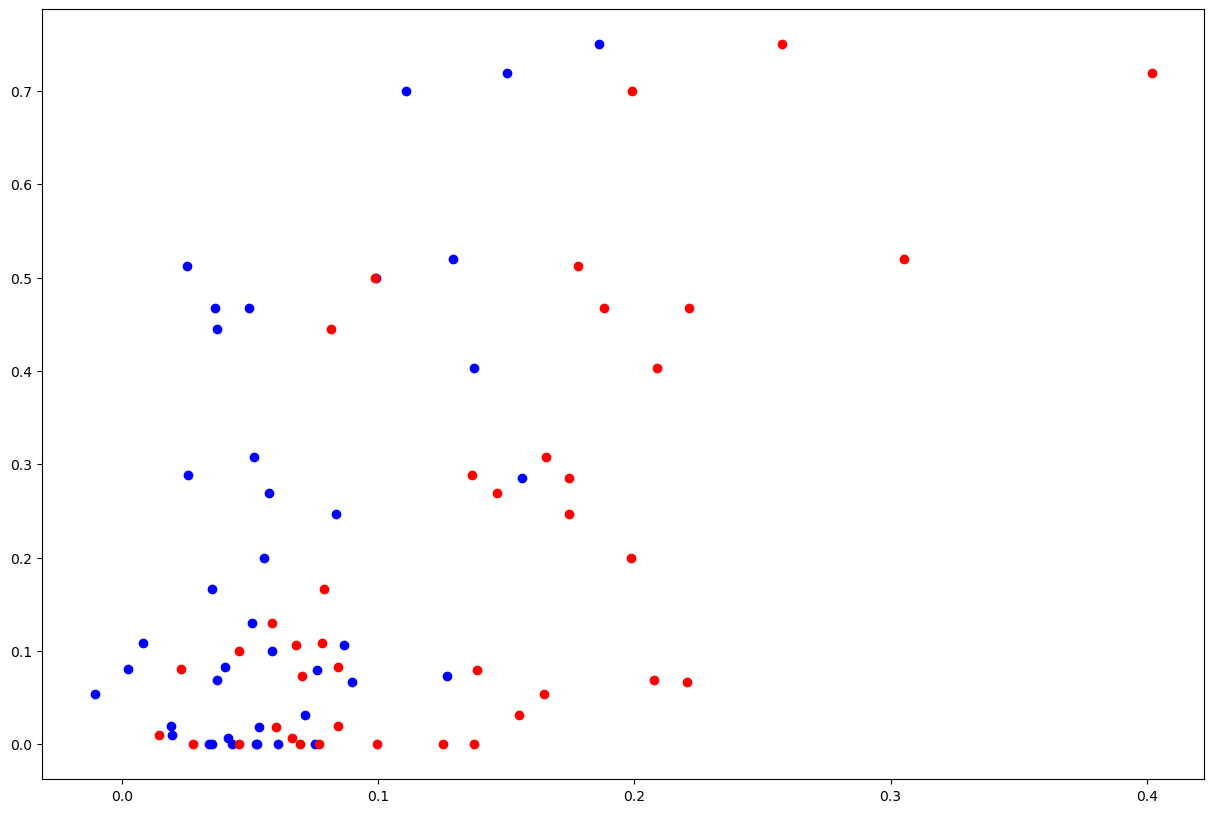

In [98]:
import numpy as np
import matplotlib.pyplot as plt

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)

plt.scatter(all_avg,all_acc,c='b')
plt.scatter(all_avg_g,all_acc,c='r')
plt.show()

In [99]:
from scipy.stats import kstest
from scipy import stats
r,p = stats.pearsonr(np.array(all_avg_g), all_acc,alternative='greater')
print('g',r,p)
r,p = stats.pearsonr(np.array(all_avg), all_acc,alternative='greater')
print(r,p)

g 0.6945071953005387 3.3291793732587393e-07
0.547259582568092 0.00012889356663159452
